Generative model for molecules + optimization of specific properties

### 0.0 Setup

In [1]:
import ast

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType
from rdkit.Chem.Draw import MolsToGridImage

RDLogger.DisableLog("rdApp.*")

### 0.1 Dataset

In [2]:
csv_path = keras.utils.get_file(
    "/pscratch/sd/v/vladygin/side_projects/ML_coding_series/VAE/250k_rndm_zinc_drugs_clean_3.csv",
    "https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv",
)

df = pd.read_csv("./250k_rndm_zinc_drugs_clean_3.csv")
df["smiles"] = df["smiles"].apply(lambda s: s.replace("\n", ""))
df.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


### 0.2 Hyperparameters

In [3]:
SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", "P", "Cl", "Br"]'

bond_mapping = {"SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2, "AROMATIC": 3}
bond_mapping.update(
    {0: BondType.SINGLE, 1: BondType.DOUBLE, 2: BondType.TRIPLE, 3: BondType.AROMATIC}
)
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)

MAX_MOLSIZE = max(df['smiles'].str.len())

SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))

atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

BATCH_size = 100
EPOCHS = 10

VAE_LR = 5e-4
NUM_ATOMS = 120 # Maximim number of atoms

ATOM_DIM = len(SMILE_CHARSET) # Number of atom types
BOND_DIM = 4 + 1 # Number of bond types
LATENT_DIM = 435 # Size of the latent space

def smiles_to_graph(smiles):
    # Convert SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)
    
    # Initialize adjacency and feature tensor
    adjusency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")
    
    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjusency[bond_type_idx, [i, j], [j, i]] = 1
            
            
    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjusency[-1, np.sum(adjusency, axis = 0) == 0] = 1
    
    # Where no atom, add 1 to last column (indicating "non atom")
    features[np.where(np.sum(features, axis = 1) == 0)[0], -1] = 1
    
    return adjusency, features

def graph_to_molecule(graph):
    # Unpack graph
    adjacency, features = graph
    
    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()
    
    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis = 1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis = (0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]
    
    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis = 1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)
        
    # Add bond between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bonds_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)
        
    # Sanitize the molecule; for more information on sanitization, see
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    # Mean take care of molecules to be resonable
    flag = Chem.SanitizeMol(molecule, catch_Errors = True)
    # Let's be strict. If sanitization faild, return None
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None
    
    return molecule



### 0.3 Generate training set

In [4]:
train_df = df.sample(frac = 0.75, random_state=42) # random state is a seed value
train_df.reset_index(drop = True, inplace = True)

adjacency_tensor, feature_tensor, qed_tensor = [], [], []
for idx in range(8000):
    adjacency, features = smiles_to_graph(train_df.loc[idx]['smiles'])
    qed = train_df.loc[idx]['qed']
    adjacency_tensor.append(adjacency)
    feature_tensor.append(features)
    qed_tensor.append(qed)
    
adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)
qed_tensor = np.array(qed_tensor)

In [5]:
# Converting input graph into NN features (initial encoder)
class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units = 128,
        activation = 'relu',
        use_bias = False,
        kernel_initializer = 'glorot_uniform',
        bias_initializer = 'zeros',
        kernel_regularizer = None,
        bias_regularizer = None,
        **kwargs
    ):
        super().__init__(**kwargs)
        
        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)
        
    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]
        
        self.kernel = self.add_weight(
            shape = (bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name = "W",
            dtype = tf.float32
        )
        
        if self.use_bias:
            self.bias = self.add_weight(
                shape = (bond_dim, 1, self.units),
                initializer=self.kernel_initializer,
                regularizer=self.kernel_regularizer,
                trainable=True,
                name = "b",
                dtype = tf.float32
            )
            
        self.build = True
        
    def call(self, inputs, training = False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Apply linear transformation
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = tf.reduce_sum(x, axis = 1)
        # Apply non linear transformation
        return self.activation(x_reduced)

### 1.0 Build Encoder and Decoder

In [6]:
def get_encoder(
    gconv_units, 
    latent_dim, 
    adjacency_shape, 
    feature_shape, 
    dense_units, 
    dropout_rate
):
    adjacency = keras.layers.Input(shape = adjacency_shape)
    features = keras.layers.Input(shape = feature_shape)
    
    # Propagate through one or more graph_convolutional layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )
        
    # Reduce 2-D representation of molecule to 1-D
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)
    
    # Propagate through one or more densely connected layers
    for units in dense_units:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
        
    z_mean = layers.Dense(latent_dim, dtype = 'float32', name = 'z_mean')(x)
    log_var = layers.Dense(latent_dim, dtype = 'float32', name = 'log_var')(x)
    
    encoder = keras.Model([adjacency, features], [z_mean, log_var], name = 'encoder')
    
    return encoder

def get_decoder(dense_units, 
                dropout_rate, 
                latent_dim, 
                adjacency_shape, 
                feature_shape):
    latent_inputs = keras.Input(shape = (latent_dim, ))
    
    x = latent_inputs
    for units in dense_units:
        x = keras.layers.Dense(units, activation = 'tanh')(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        
    # Map outputs of previous layer (x) to [continous] adjucency tensor (x_adjucency)
    x_adjacency = keras.layers.Dense(tf.math.reduce_prod(adjacency_shape))(x)
    x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)
    # Symmetrify the tensor in the last two dimensions
    x_adjacency = (x_adjacency + tf.transpose(x_adjacency, (0, 1, 3, 2))) / 2
    x_adjacency = keras.layers.Softmax(axis = 1)(x_adjacency)
    
    # Map output of previous layer (x) to [continious] feature tensors (x_features)
    x_features = keras.layers.Dense(tf.math.reduce_prod(feature_shape))(x)
    x_features = keras.layers.Reshape(feature_shape)(x_features)
    x_features = keras.layers.Softmax(axis = 1)(x_features)
    
    decoder = keras.Model(
        latent_inputs, outputs = [x_adjacency, x_features], name = 'decoder'
    )
    
    return decoder

### 1.1 Build Sample layer

In [7]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_log_var)[0]
        dim = tf.shape(z_log_var)[1]
        epsilon = tf.keras.backend.random_normal(shape = (batch, dim))
        
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### 1.2 Build the VAE

In [8]:
class MoleculeGenerator(keras.Model):
    def __init__(self, encoder, decoder, max_len, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.property_prediction_layer = layers.Dense(1)
        
        self.max_len = max_len
        
        self.train_total_loss_tracker = keras.metrics.Mean(name = "train_total_loss")
        self.val_total_loss_tracker = keras.metrics.Mean(name = "val_total_loss")
        
    def train_step(self, data):
        
        adjacency_tensor, feature_tensor, qed_tensor = data[0]
        graph_real = [adjacency_tensor, feature_tensor]
        self.batch_size = tf.shape(qed_tensor)[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, qed_pred, gen_adjacency, gen_features = self(
                graph_real, training = True
            )
            graph_generated = [gen_adjacency, gen_features]
            total_loss = self._compute_loss(
                z_log_var, z_mean, qed_tensor, qed_pred, graph_real, graph_generated
            )
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.train_total_loss_tracker.update_state(total_loss)
        
        return {"loss": self.train_total_loss_tracker.result()}
    
    
    def _compute_loss(
        self, z_log_var, z_mean, qed_true, qed_pred, graph_real, graph_generated
    ):
        adjacency_real, features_real = graph_real
        adjacency_gen, features_gen = graph_generated
        
        adjacency_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.categorical_crossentropy(adjacency_real, adjacency_gen),
                axis = (1, 2)
            )
        )
        
        features_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.categorical_crossentropy(features_real, features_gen),
                axis = (1),
            )
        )
        
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), 1
        )
        kl_loss = tf.reduce_mean(kl_loss)
        
        property_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(qed_true, qed_pred)
        )
        
        graph_loss = self._gradient_penalty(graph_real, graph_generated)
        
        return kl_loss + property_loss + graph_loss + adjacency_loss + features_loss
    
    def _gradient_penalty(self, graph_real, graph_generated):
        # Unpack graphs
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated
        
        # Generate interpolated graphs (adjacency_interp and features_interp)
        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        features_interp = (features * alpha) + (1 - alpha) * features_generated
        
        # Compute the logits of interpolated graphs
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            _, _, logits, _, _ = self(
                [adjacency_interp, features_interp], training = True
            )
            
            
        # Compute the gradients with respect to the interpolated graphs
        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        # Compute the gradient penalty
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis = 1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis = 2)) ** 2
        
        return tf.reduce_mean(
            tf.reduce_mean(grads_adjacency_penalty, axis = (-2, -1))
            + tf.reduce_mean(grads_features_penalty, axis = (-1))
        )
            
    def inference(self, batch_size):
        z = tf.random.normal((batch_size, LATENT_DIM))
        reconstructed_adjacency, reconstructed_features = model.decoder.predict(z)
        
        # obtain one-hot encoded adjacency tensor
        adjacency = tf.argmax(reconstructed_adjacency, axis = 1)
        adjacency = tf.one_hot(adjacency, depth = BOND_DIM, axis = 1)
        # Remove potential self-loops from adjucency
        adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
        
        # obtain one-hot encoded feature tensor
        features = tf.argmax(reconstructed_features, axis = 2)
        features = tf.one_hot(features, depth = ATOM_DIM, axis = 2)
        
        return [
            graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
            for i in range(batch_size)
        ]
    
    def call(self, inputs):
        z_mean, log_var = self.encoder(inputs)
        z = Sampling()([z_mean, log_var])
        
        gen_adjacency, gen_features = self.decoder(z_mean)
        
        property_pred = self.property_prediction_layer(z_mean)
        
        return z_mean, log_var, property_pred, gen_adjacency, gen_features
    


### 2.0 Train the model

In [9]:
vae_optimizer = tf.keras.optimizers.Adam(learning_rate=VAE_LR)

encoder = get_encoder(
    gconv_units = [9],
    adjacency_shape = (BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape = (NUM_ATOMS, ATOM_DIM),
    latent_dim = LATENT_DIM,
    dense_units = [512],
    dropout_rate = 0.0,
)

decoder = get_decoder(
    dense_units = [128, 256, 512],
    dropout_rate = 0.2,
    latent_dim = LATENT_DIM,
    adjacency_shape = (BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape= (NUM_ATOMS, ATOM_DIM),
)

model = MoleculeGenerator(encoder, decoder, MAX_MOLSIZE)

model.compile(vae_optimizer)
history = model.fit([adjacency_tensor, feature_tensor, qed_tensor], epochs = EPOCHS)

Epoch 1/10
250/250 [==============================] - 4s 6ms/step - loss: 69026.4935
Epoch 2/10
250/250 [==============================] - 1s 6ms/step - loss: 68802.0453
Epoch 3/10
250/250 [==============================] - 1s 6ms/step - loss: 68795.8117
Epoch 4/10
250/250 [==============================] - 1s 6ms/step - loss: 68794.1044
Epoch 5/10
250/250 [==============================] - 1s 6ms/step - loss: 68792.7257
Epoch 6/10
250/250 [==============================] - 1s 6ms/step - loss: 68791.8735
Epoch 7/10
250/250 [==============================] - 1s 6ms/step - loss: 68791.9620
Epoch 8/10
250/250 [==============================] - 1s 6ms/step - loss: 68791.0801
Epoch 9/10
250/250 [==============================] - 1s 6ms/step - loss: 68789.9731
Epoch 10/10
250/250 [==============================] - 1s 6ms/step - loss: 68796.0627


### 3.0 Inference

In [15]:
print(molecules[0])

None


In [16]:
model.inference(1)

1/1 [==============================] - 0s 55ms/step


[None]

250/250 [==============================] - 0s 2ms/step


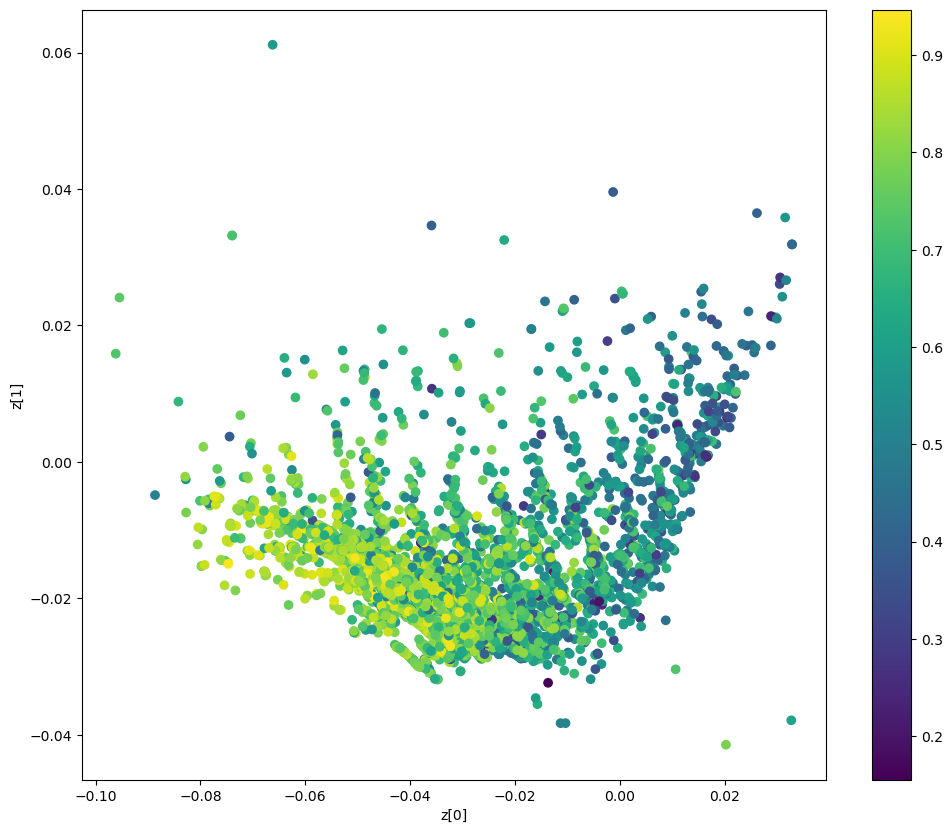

In [88]:
def plot_latent(vae, data, labels):
    # Display a 2D plot of the property in the latent space
    z_mean, _ = vae.encoder.predict(data)
    
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c = labels)
    
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    
    plt.show()
    
plot_latent(model, [adjacency_tensor[:8000], feature_tensor[:8000]], qed_tensor[:8000])